# Applying `elo-grad` to NBA data

This notebook provides example usage of applying the `elo-grad` package to NBA data. This is based on this example notebook in the [kickscore](https://github.com/lucasmaystre/kickscore) package.

To install all the dependencies required for this notebook (and any other example notebooks), run `pip install elo-grad[examples]`.

In [1]:
import datetime
import sys

import matplotlib.pyplot as plt
import polars as pl
from sklearn.calibration import calibration_curve
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from elo_grad import EloEstimator, Regressor


print(f'Python {sys.version} on {sys.platform}.')

Python 3.10.11 (main, Dec 16 2023, 21:35:16) [GCC 11.4.0] on linux.


## Getting the data

We use NBA data from [538](https://abcnews.go.com/538) under the [Creative Commons Attribution 4.0 License](https://creativecommons.org/licenses/by/4.0/).

**NOTE:** the below will not run on Windows machines. Manually download the CSV if that is the case.

In [2]:
! ! test -f ./data/nba_elo.csv && curl https://projects.fivethirtyeight.com/nba-model/nba_elo.csv -o ./data/nba_elo.csv

/home/mike/.pyenv/versions/3.10.11/lib/python3.10/pty.py:89: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid, fd = os.forkpty()


## Processing the data

In [3]:
df = (
    pl.read_csv(
        './data/nba_elo.csv',
        columns=['date', 'team1', 'team2', 'score1', 'score2', 'neutral'],
        schema_overrides={'team1': pl.Categorical, 'team2': pl.Categorical},
        try_parse_dates=True,
    )
    .sort('date', descending=False)
    # There are some duplicates here (with respect to date/team1/team2)
    .unique(subset=['date', 'team1', 'team2', 'score1', 'score2', 'neutral'], keep='first', maintain_order=True)
    # Get Unix timestamp (in seconds)
    .with_columns((24 * 60 * 60 * pl.col('date').cast(pl.Int64)).alias('t'))
)
print(f'We have {df.shape[0]:,} matches.')
df.head()

We have 73,363 matches.


date,neutral,team1,team2,score1,score2,t
date,i64,cat,cat,i64,i64,i64
1946-11-01,0,"""TRH""","""NYK""",66,68,-731116800
1946-11-02,0,"""PRO""","""BOS""",59,53,-731030400
1946-11-02,0,"""STB""","""PIT""",56,51,-731030400
1946-11-02,0,"""CHS""","""NYK""",63,47,-731030400
1946-11-02,0,"""DTF""","""WSC""",33,50,-731030400


Quick check for nulls.

In [4]:
df.null_count()

date,neutral,team1,team2,score1,score2,t
u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0


Assign a *result* field, based on the score and a *home* field.

In [5]:
df = df.with_columns(
    (pl.col('score1') > pl.col('score2')).cast(pl.Int8).alias('result'),
    (pl.col('neutral') != 1).cast(pl.Int8).alias('home'),
)
df.head()

date,neutral,team1,team2,score1,score2,t,result,home
date,i64,cat,cat,i64,i64,i64,i8,i8
1946-11-01,0,"""TRH""","""NYK""",66,68,-731116800,0,1
1946-11-02,0,"""PRO""","""BOS""",59,53,-731030400,1,1
1946-11-02,0,"""STB""","""PIT""",56,51,-731030400,1,1
1946-11-02,0,"""CHS""","""NYK""",63,47,-731030400,1,1
1946-11-02,0,"""DTF""","""WSC""",33,50,-731030400,0,1


## Train/val split

Split data into training and validation sets.
We later use the training data for setting model hyper-parameters.

In [6]:
split_date = datetime.date(2022, 1, 1)

cols = ['team1', 'team2', 'result', 't', 'home']

X_train, X_val = df.filter(pl.col('date') < split_date).select(cols), df.filter(pl.col('date') >= split_date).select(cols)

## Benchmark

Let's do a performance benchmark.

In [7]:
%%timeit -n 20
elo = EloEstimator(entity_cols=('team1', 'team2'), score_col='result', date_col='t', beta=200, k_factor=20, default_init_rating=1500)

elo.fit(X_train)

299 ms ± 8.78 ms per loop (mean ± std. dev. of 7 runs, 20 loops each)


## Get predictions/ratings

Use the `fit` method to calculate expected scores/ratings.

In [8]:
elo = EloEstimator(
    entity_cols=('team1', 'team2'), 
    score_col='result', 
    beta=200, 
    k_factor=20, 
    default_init_rating=1500,
    track_rating_history=True,
)

preds = elo.fit(X_train)
sorted(elo.model.ratings.items(), key=lambda item: item[1][1], reverse=True)[:10]

[('NYA', (200880000, 1752.4993905560714)),
 ('PHO', (1640908800, 1724.2693228040669)),
 ('DNA', (200880000, 1722.1502996260365)),
 ('SAA', (199238400, 1697.714132858372)),
 ('UTA', (1640908800, 1692.748642484585)),
 ('PHW', (-244166400, 1668.9309130275058)),
 ('MIL', (1640908800, 1668.7161332602009)),
 ('GSW', (1640736000, 1668.3024920876876)),
 ('KEN', (199584000, 1657.5269803297504)),
 ('BRK', (1640908800, 1656.6780727309192))]

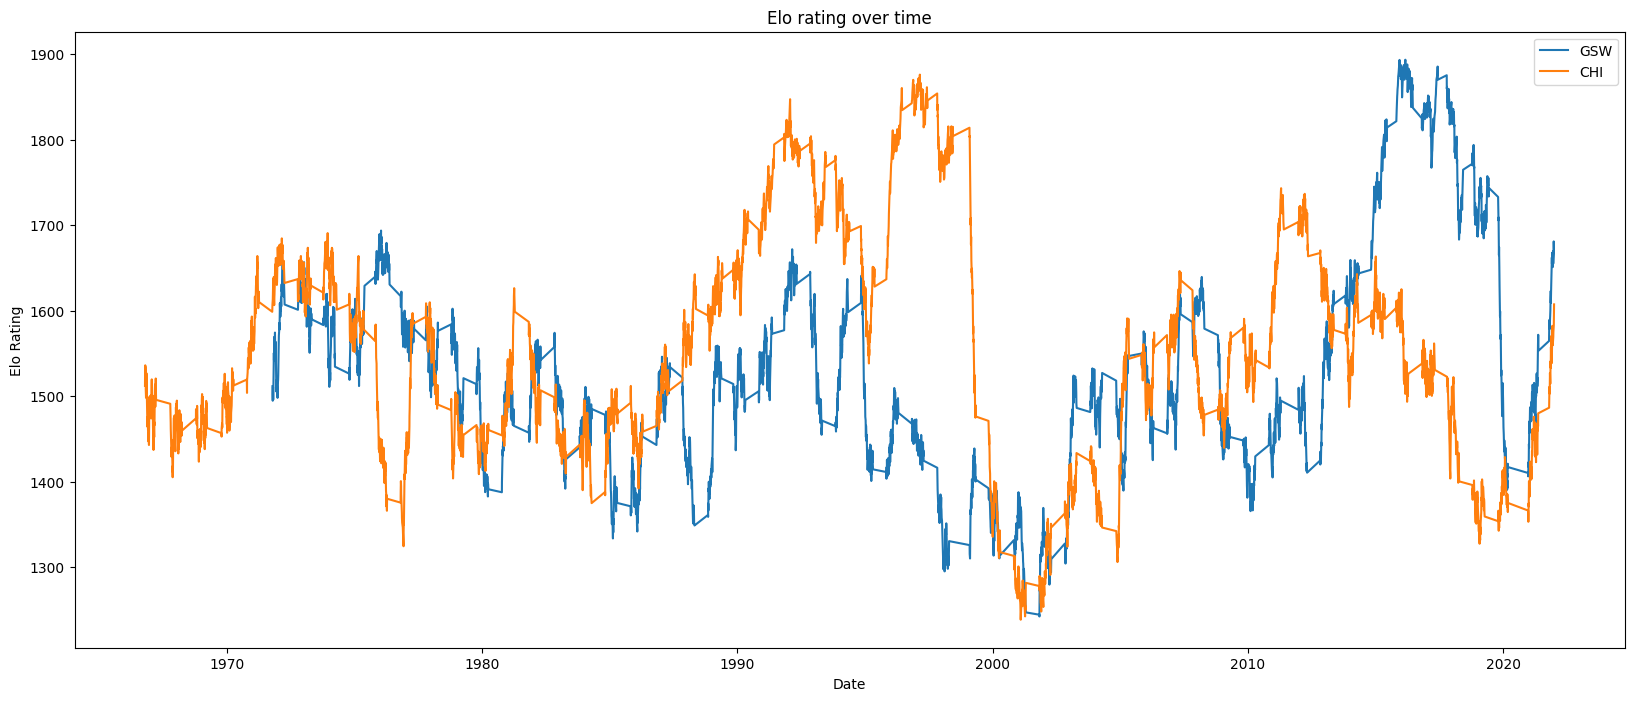

In [9]:
fig, ax = plt.subplots(figsize=(20, 8))
elo.plot(['GSW', 'CHI'], ax=ax)
plt.show()

## Evaluate the predictions

In [10]:
y_val_pred = elo.predict_proba(X_val)[:, 1]
print(f"Validation set log-loss: {log_loss(X_val['result'], y_val_pred):.4f}")

Validation set log-loss: 0.6580


Check the calibration.

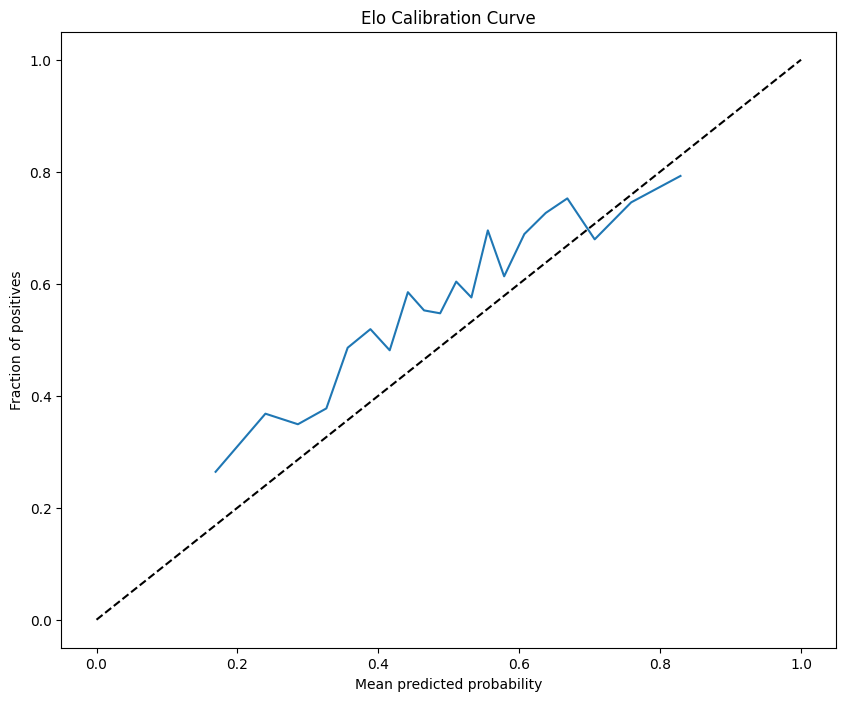

In [11]:
prob_true, prob_pred = calibration_curve(X_val['result'], y_val_pred, n_bins=20, strategy='quantile')

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(prob_pred, prob_true)
ax.plot([0, 1], [0, 1], color='black', linestyle='--')
ax.set(
    title='Elo Calibration Curve',
    xlabel='Mean predicted probability',
    ylabel='Fraction of positives',
)

plt.show()

## Grid search

As our estimator is `scikit-learn` compatible, we can use `scikit-learn` to do things like perform a grid search over hyper-parameters.

In [12]:
gs = GridSearchCV(
    estimator=EloEstimator(entity_cols=('team1', 'team2'), score_col='result'), 
    param_grid={
        'beta': [200],
        'k_factor': [10, 100],
    },
    cv=TimeSeriesSplit(n_splits=3),
)
gs.fit(X_train, X_train['result'])
pl.DataFrame(gs.cv_results_).sort('mean_test_score', descending=False)

/home/mike/PycharmProjects/elo-grad/.venv/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_beta,param_k_factor,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
f64,f64,f64,f64,i64,i64,struct[2],f64,f64,f64,f64,f64,i32
0.279005,0.008425,0.112189,0.019831,200,10,"{200,10}",0.640402,0.632654,0.636501,0.636519,0.003163,2
0.21795,0.120991,0.124444,0.035428,200,100,"{200,100}",0.694953,0.676101,0.679805,0.683619,0.008155,1


## Home advantage

We can add an additional regressor to capture the effect of home advantage.
We use a smaller scale factor and set the initial rating to `0` for this additional regressor.

In [13]:
elo_home = EloEstimator(
    entity_cols=('team1', 'team2'), 
    score_col='result', 
    beta=200, 
    k_factor=20, 
    default_init_rating=1500,
    init_ratings=dict(home=(None, 0)),
    additional_regressors=[Regressor(name='home', k_factor=0.1)],
    track_rating_history=True,
)

preds = elo_home.fit(X_train)
sorted(elo_home.model.ratings.items(), key=lambda item: item[1][1], reverse=True)[:10]

[('NYA', (200880000, 1758.473809039039)),
 ('DNA', (200880000, 1734.1628165478007)),
 ('PHO', (1640908800, 1728.312774197984)),
 ('SAA', (199238400, 1699.9695305063665)),
 ('UTA', (1640908800, 1691.8060310727476)),
 ('PHW', (-244166400, 1682.594128534709)),
 ('MIL', (1640908800, 1680.926902625327)),
 ('GSW', (1640736000, 1668.1888783525424)),
 ('KEN', (199584000, 1661.7233549008185)),
 ('BRK', (1640908800, 1660.197977271172))]

We see that adding this regressor reduces the log-loss.

In [14]:
y_val_pred_home = elo_home.predict_proba(X_val)[:, 1]
print(f"Validation set log-loss: {log_loss(X_val['result'], y_val_pred_home):.4f}")

Validation set log-loss: 0.6474


We can also visualise the home advantage effect over time.

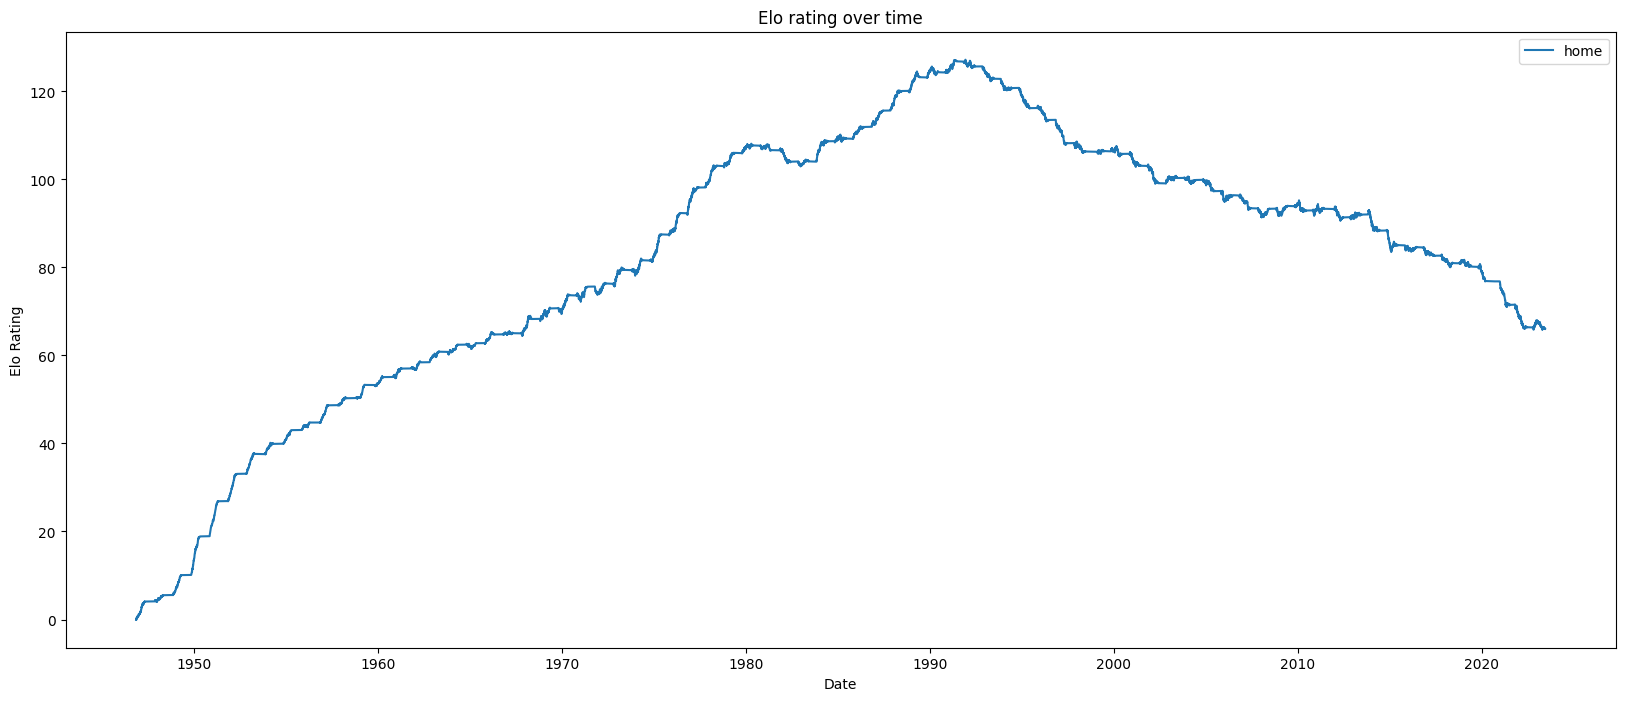

In [15]:
fig, ax = plt.subplots(figsize=(20, 8))
elo_home.plot(['home'], ax=ax)
plt.show()

Let's benchmark performance when we add in home advantage.

In [16]:
%%timeit -n 20
elo_home = EloEstimator(
    entity_cols=('team1', 'team2'), 
    score_col='result', 
    beta=200, 
    k_factor=20, 
    default_init_rating=1500,
    init_ratings=dict(home=(None, 0)),
    additional_regressors=[Regressor(name='home', k_factor=0.1)],
)

elo_home.fit(X_train)

598 ms ± 112 ms per loop (mean ± std. dev. of 7 runs, 20 loops each)


### Regularisation

We can also apply regularisation to the home weights.

In [17]:
elo_home_reg = EloEstimator(
    entity_cols=('team1', 'team2'), 
    score_col='result', 
    beta=200, 
    k_factor=20, 
    default_init_rating=1500,
    init_ratings=dict(home=(None, 0)),
    additional_regressors=[Regressor(name='home', k_factor=0.1, penalty='l2', lambda_reg=1e-4)],
    track_rating_history=True,
)

preds = elo_home_reg.fit(X_train)
sorted(elo_home_reg.model.ratings.items(), key=lambda item: item[1][1], reverse=True)[:10]

[('NYA', (200880000, 1757.0352820255523)),
 ('DNA', (200880000, 1731.8476964931042)),
 ('PHO', (1640908800, 1726.651283850169)),
 ('SAA', (199238400, 1699.1152474937408)),
 ('UTA', (1640908800, 1691.0940414379588)),
 ('PHW', (-244166400, 1681.8765248327143)),
 ('MIL', (1640908800, 1677.916830033547)),
 ('GSW', (1640736000, 1667.8736554028376)),
 ('KEN', (199584000, 1660.6941605037102)),
 ('BRK', (1640908800, 1658.8816196265366))]

We see that adding this regressor reduces the log-loss.

In [18]:
y_val_pred_home_reg = elo_home_reg.predict_proba(X_val)[:, 1]
print(f"Validation set log-loss: {log_loss(X_val['result'], y_val_pred_home_reg):.4f}")

Validation set log-loss: 0.6467


and changes the ratings:

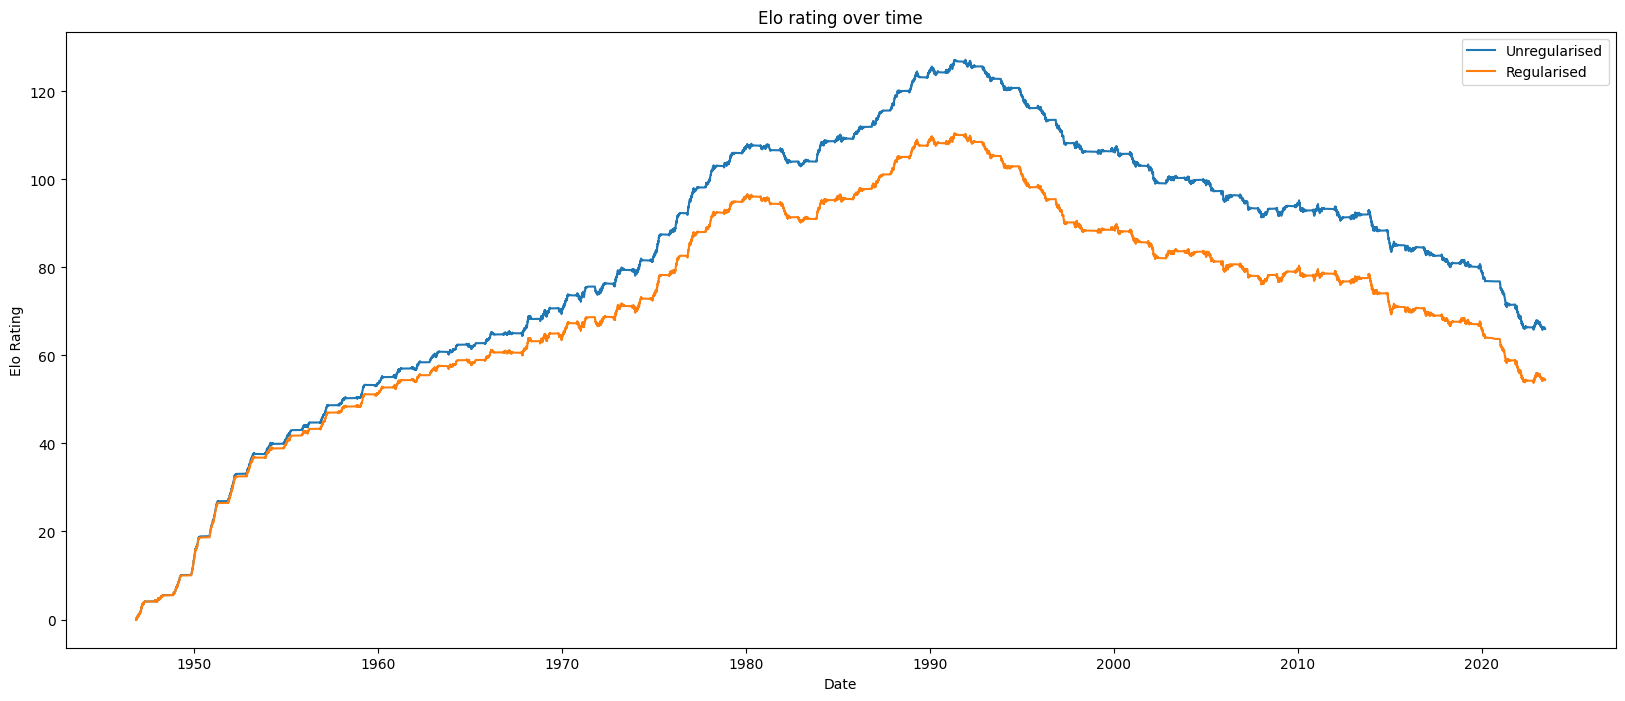

In [19]:
fig, ax = plt.subplots(figsize=(20, 8))
elo_home.plot(['home'], ax=ax, labels=['Unregularised'])
elo_home_reg.plot(['home'], ax=ax, labels=['Regularised'])
plt.show()